In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from tqdm import tqdm

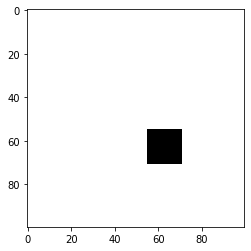

In [22]:
black_square = np.ones((100, 100))
black_square[55:71, 55:71] = 0
plt.imshow(black_square, cmap="gray")

100%|██████████| 100/100 [00:00<00:00, 1658.48it/s]


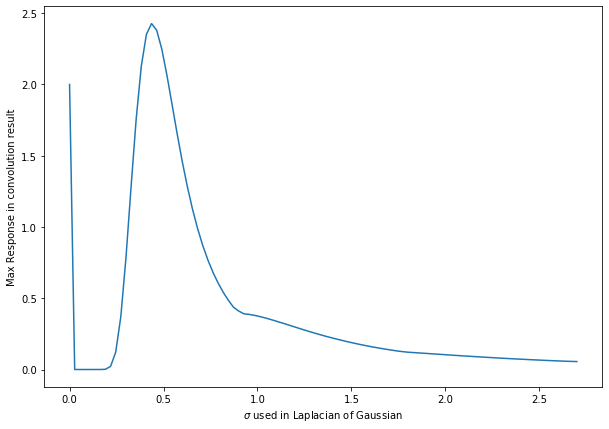

In [25]:
sigma = []
response = []

for i in tqdm(np.linspace(0, 2.7, 100)):
    laplacian = ndimage.gaussian_laplace(black_square, sigma = i)
    sigma.append(i)
    response.append(np.max(laplacian))
        
plt.figure(figsize=(10, 7))
plt.xlabel("$\sigma$ used in Laplacian of Gaussian")
plt.ylabel("Max Response in convolution result")
plt.plot(sigma, response)
plt.show()

## Q2) RANSAC

In [4]:
def apply_affine(vectors, M):
    assert M.shape == (2, 3)
    linear_map, displacement = M[:2, :2], M[0:, 2:]
    return (linear_map @ vectors.T).T + displacement.squeeze()

In [5]:
book_cover = cv2.imread("./Q2/Book_cover.jpg", cv2.IMREAD_GRAYSCALE)
book_pic = cv2.imread("./Q2/Book_pic.png", cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()

kp1_SIFT, desc1_SIFT = sift.detectAndCompute(book_cover, None)
kp2_SIFT, desc2_SIFT = sift.detectAndCompute(book_pic, None)

kp1, kp2, desc1, desc2 = kp1_SIFT, kp2_SIFT, desc1_SIFT, desc2_SIFT

In [6]:
# (brute force) matching of descriptors
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

# Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
good_matches = []
good_matches_without_list = []
for m, n in matches:
    if m.distance < 0.75 * n.distance: # only accept matchs that are considerably better than the 2nd best match
        good_matches.append([m])
        good_matches_without_list.append(m) # this is to simplify finding a homography later

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2).squeeze()
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2).squeeze()
print(src_pts.shape, dst_pts.shape)
N, _ = src_pts.shape

(672, 2) (672, 2)


In [7]:
# S = log(1 - P)/ log(1 - p ** k)
p, k, P = 0.5, 3, 0.995
S = int(np.ceil(np.log(1 - P) / np.log(1 - (p ** k))))

best_affine_M = None
best_qualify_num = -np.inf

for i in tqdm(range(S * 10)):
    rand_indices = np.random.randint(N, size=3)
    random_src = src_pts[rand_indices]
    random_dst = dst_pts[rand_indices]
    affine_M = cv2.getAffineTransform(random_src, random_dst)

    # transform all src into dst using this estimation
    estimated_dst = apply_affine(src_pts, affine_M)
    qualified_count = np.sum(np.sqrt(np.sum((estimated_dst - dst_pts) ** 2, axis=1)) <= 5)
    
    if qualified_count > best_qualify_num:
        best_qualify_num = qualified_count
        best_affine_M = affine_M

print(f"best_affine_M \n{best_affine_M}\n with number of matches {best_qualify_num}")

100%|██████████| 400/400 [00:00<00:00, 9169.08it/s]

best_affine_M 
[[ 7.05165454e-02 -2.26856334e-01  4.24297871e+02]
 [ 2.25433564e-01  1.91136836e-02  1.45427886e+02]]
 with number of matches 245


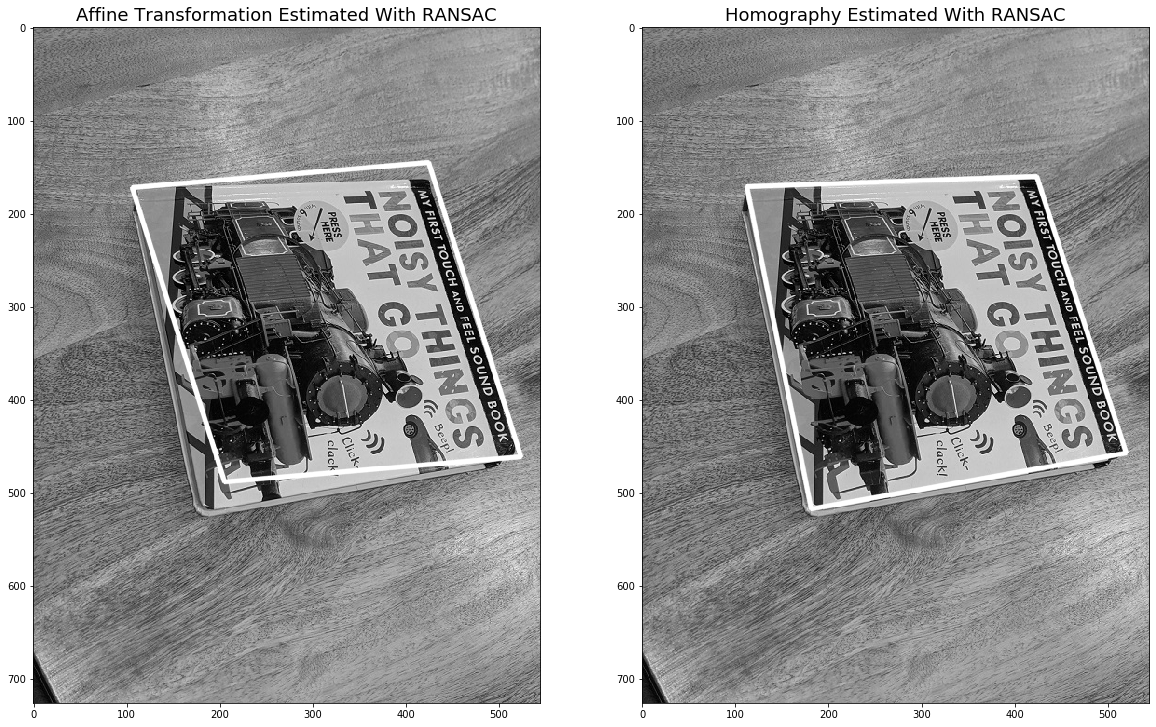

In [38]:
# prepare the affine marked image
h, w = book_cover.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])
detected_book = apply_affine(pts, best_affine_M)
affine_marked = cv2.polylines(book_pic.copy(), [np.int32(detected_book)], True, 255, 3, cv2.LINE_AA)

# prepare the homography marked image
homography_M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
pts = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
detected_book = cv2.perspectiveTransform(pts, homography_M)
homography_marked = cv2.polylines(book_pic.copy(),[np.int32(detected_book)],True,255,3, cv2.LINE_AA)

# plot the two marked images side by side. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

ax1.imshow(affine_marked, 'gray')
ax1.set_title("Affine Transformation Estimated With RANSAC", size=18)
ax2.imshow(homography_marked, 'gray')
ax2.set_title("Homography Estimated With RANSAC", size=18)

fig.savefig("./figs/affine_homography_compare.pdf", bbox_inches='tight', pad_inches=0)

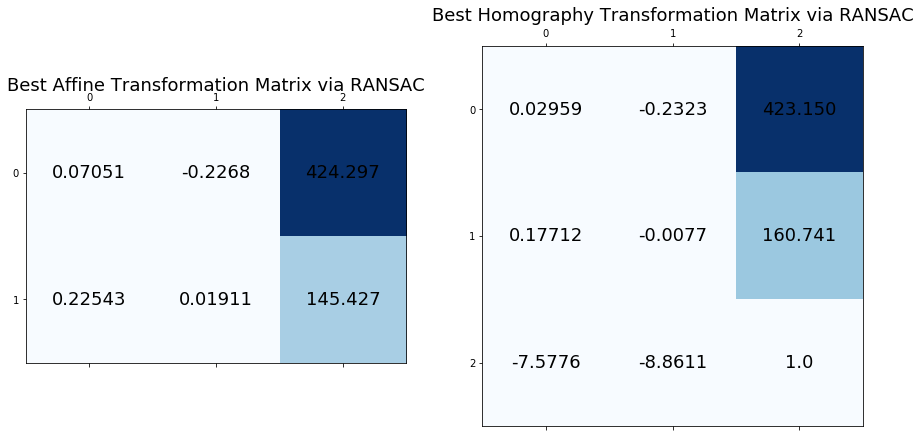

In [58]:
# compare the matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.matshow(best_affine_M, cmap=plt.cm.Blues)
ax1.set_title("Best Affine Transformation Matrix via RANSAC", size=18)
for i in range(best_affine_M.shape[1]):
    for j in range(best_affine_M.shape[0]):
        c = best_affine_M[j,i]
        ax1.text(i, j, str(c)[:7], va='center', ha='center', size=18)

ax2.matshow(homography_M, cmap=plt.cm.Blues)
ax2.set_title("Best Homography Transformation Matrix via RANSAC", size=18)
for i in range(homography_M.shape[1]):
    for j in range(homography_M.shape[0]):
        c = homography_M[j,i]
        ax2.text(i, j, str(c)[:7], va='center', ha='center', size=18)